In [1]:
import re
import string

!pip install -U nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize # Sentence Tokenizer
from nltk.tokenize import word_tokenize # Word Tokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Requirement already up-to-date: nltk in /anaconda3/lib/python3.7/site-packages (3.4)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samirgadkari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samirgadkari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1) (optional) Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

In [68]:
import requests
from bs4 import BeautifulSoup, SoupStrainer
import time

HTML_OK = 200
NUM_RETRIES = 5
TIMEOUT = 5       # timeout in seconds

def get_listing(link):
    print('link:', link)
    r = requests.get(link)
    print('status:', r.status_code)
    # print(r.content)
    soup = BeautifulSoup(r.content)
 
    title = soup.find(attrs={'class': 'jobsearch-JobInfoHeader-title'}) \
                .get_text()
    description = soup.find(attrs={'class': 'jobsearch-JobComponent-description'}) \
                    .get_text()
        
    return {'title': title, 'description': description}

def process_page(r):
    strainer = SoupStrainer('a')
    soup = BeautifulSoup(r.content, parse_only=strainer)
    
    urls = soup.find_all(attrs={'data-tn-element': 'jobTitle'})
    res = []
    for url in urls:
        if url['href'].startswith('/rc'):
            res.append(get_listing('https://www.indeed.com/' + url['href']))

    return res

def get_page(docs_required = 100, docs_completed = 0, start = 0,
             current = 'https://www.indeed.com/' \
                       'jobs?q=data%20scientist&l=San%20Jose%20CA'):
    
    if (current == None):
        if start == 0:
            current = 'https://www.indeed.com/jobs?' \
                      'q=data%20scientist&l=San%20Jose%20CA'
        else:
            current = 'https://www.indeed.com/jobs?' \
                      'q=data%20scientist&l=San%20Jose%20CA&start=' \
                        + str(start)

    try:
        for i in range(NUM_RETRIES):
            r = requests.get(current)
            if r.status_code != HTML_OK:
                print('Error: Status code:', r.status_code)
                print('  Error getting data from:', current)
            else:
                res = process_page(r)
                break
            time.sleep(TIMEOUT)
    except:
        print("Unexpected error:", sys.exc_info()[0])
        raise
    
    # print(res)

## One thing left here is to paging to get the next set of 10 links, until we got all the data we need.

In [69]:
get_page(100, 0, 0)

link: https://www.indeed.com//rc/clk?jk=c2ad1b6e76be77f9&fccid=804a47dd3ecffda7&vjs=3
status: 200
link: https://www.indeed.com//rc/clk?jk=96853b13c30b8e92&fccid=ec7026b814653f27&vjs=3
status: 200
link: https://www.indeed.com//rc/clk?jk=0c47ce0f5049af94&fccid=ab1f45b81c4d4c99&vjs=3
status: 200
link: https://www.indeed.com//rc/clk?jk=97bf07d813384394&fccid=f89deb5a97c7738a&vjs=3
status: 200
link: https://www.indeed.com//rc/clk?jk=163fa32794357a19&fccid=a5b4499d9e91a5c6&vjs=3
status: 200
link: https://www.indeed.com//rc/clk?jk=fe876a266c538841&fccid=f89deb5a97c7738a&vjs=3
status: 200
link: https://www.indeed.com//rc/clk?jk=9ce4ee2aad5534c3&fccid=b868f07d84101767&vjs=3
status: 200
link: https://www.indeed.com//rc/clk?jk=9d601b6d2be4f99c&fccid=1b866506aec22461&vjs=3
status: 200
link: https://www.indeed.com//rc/clk?jk=418ed43b663ecac5&fccid=69c7d55b78dc7424&vjs=3
status: 200
link: https://www.indeed.com//rc/clk?jk=e56c15ad5daa0a8a&fccid=1503f9b2e8718009&vjs=3
status: 200


## 2) Use NLTK to tokenize / clean the listings 

In [31]:
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup


def get_content(l):
    soup = BeautifulSoup(l, 'html.parser')
    res = []
    for tag in soup.find_all(True):
        if tag.string != None:
            res.append(tag.string)
    return ' '.join(res)


def remove_stopwords(l):
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')    # NLTK has a list of stopwords you can use.
    
    return [w for w in l if w not in stop_words]

with open('job_listings.csv', 'r') as f:
    listings = f.readlines()

words_per_listing = []
for l in listings:
    content = get_content(l)
    lowercase = content.lower()                # Lowercase before removing stopwords.
    tokens = word_tokenize(lowercase)

    words = [w for w in tokens if w.isalpha()] # Keep only words with alphabet characters.
                                               # isalpha() is True if all characters
                                               # are alphabetic.
    
    # words = get_words(l)
    words = remove_stopwords(words)
    words_per_listing.append(words)

# print('stopwords:', stopwords.words('english'))
print('words_per_listing:', words_per_listing[1])

words_per_listing: ['job', 'requirements', 'understanding', 'machine', 'learning', 'models', 'like', 'bayes', 'svm', 'apriori', 'logistic', 'regression', 'neural', 'random', 'forests', 'decision', 'trees', 'along', 'experience', 'least', 'intermediate', 'expert', 'level', 'coding', 'skills', 'ability', 'write', 'functions', 'clean', 'efficient', 'data', 'manipulation', 'mandatory', 'role', 'exposure', 'packages', 'like', 'numpy', 'scipy', 'pandas', 'matplotlib', 'etc', 'python', 'dplyr', 'tidyr', 'r', 'ability', 'communicate', 'model', 'findings', 'technical', 'stake', 'holders', 'hands', 'experience', 'similar', 'programming', 'language', 'must', 'show', 'past', 'work', 'via', 'github', 'kaggle', 'published', 'article', 'master', 'degree', 'science', 'quant', 'specific', 'field', 'master', 'degree', 'science', 'quant', 'specific', 'field']


# 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

# Let's get the words into a single string per document.
# This is what the CountVectorizer expects.
all_content = []
for l in listings:
    content = get_content(l)
    all_content.append(content)

# print(content)
before_cleaning_bag_of_words = vectorizer.fit_transform(all_content)
print(before_cleaning_bag_of_words.shape[0])
names = vectorizer.get_feature_names()
print(len(names))

427
7889


In [43]:
vectorizer = CountVectorizer()

# CountVectorizer requires a sentence of words per document.
sentences = []
for words in words_per_listing:
    sentences.append(' '.join(words))

after_cleaning_bag_of_words = vectorizer.fit_transform(sentences)    
print(after_cleaning_bag_of_words.shape[0])
names = vectorizer.get_feature_names()
print(len(names))

427
6426


### Notice that the number of features is reduced a lot (20%) if we clean the data before using the CountVectorizer

In [56]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

stemmed = []
for l in words_per_listing:
    stemmed.append([stemmer.stem(w) for w in l])
print(stemmed[1])

['job', 'requir', 'understand', 'machin', 'learn', 'model', 'like', 'bay', 'svm', 'apriori', 'logist', 'regress', 'neural', 'random', 'forest', 'decis', 'tree', 'along', 'experi', 'least', 'intermedi', 'expert', 'level', 'code', 'skill', 'abil', 'write', 'function', 'clean', 'effici', 'data', 'manipul', 'mandatori', 'role', 'exposur', 'packag', 'like', 'numpi', 'scipi', 'panda', 'matplotlib', 'etc', 'python', 'dplyr', 'tidyr', 'r', 'abil', 'commun', 'model', 'find', 'technic', 'stake', 'holder', 'hand', 'experi', 'similar', 'program', 'languag', 'must', 'show', 'past', 'work', 'via', 'github', 'kaggl', 'publish', 'articl', 'master', 'degre', 'scienc', 'quant', 'specif', 'field', 'master', 'degre', 'scienc', 'quant', 'specif', 'field']


# 4) Visualize the most common word counts

In [57]:
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

lemmatized = []
for l in words_per_listing:
    lemmatized.append([lemmatizer.lemmatize(w) for w in l])
print(lemmatized[1])

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samirgadkari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['job', 'requirement', 'understanding', 'machine', 'learning', 'model', 'like', 'bayes', 'svm', 'apriori', 'logistic', 'regression', 'neural', 'random', 'forest', 'decision', 'tree', 'along', 'experience', 'least', 'intermediate', 'expert', 'level', 'coding', 'skill', 'ability', 'write', 'function', 'clean', 'efficient', 'data', 'manipulation', 'mandatory', 'role', 'exposure', 'package', 'like', 'numpy', 'scipy', 'panda', 'matplotlib', 'etc', 'python', 'dplyr', 'tidyr', 'r', 'ability', 'communicate', 'model', 'finding', 'technical', 'stake', 'holder', 'hand', 'experience', 'similar', 'programming', 'language', 'must', 'show', 'past', 'work', 'via', 'github', 'kaggle', 'published', 'article', 'master', 'degree', 'science', 'quant', 'specific', 'field', 'master', 'degree', 'science', 'quant', 'specific', 'field']


In [52]:
from nltk.probability import FreqDist

fdist = FreqDist(lemmatized[1])
fdist.most_common(20)

[('model', 2),
 ('like', 2),
 ('experience', 2),
 ('ability', 2),
 ('master', 2),
 ('degree', 2),
 ('science', 2),
 ('quant', 2),
 ('specific', 2),
 ('field', 2),
 ('job', 1),
 ('requirement', 1),
 ('understanding', 1),
 ('machine', 1),
 ('learning', 1),
 ('bayes', 1),
 ('svm', 1),
 ('apriori', 1),
 ('logistic', 1),
 ('regression', 1)]

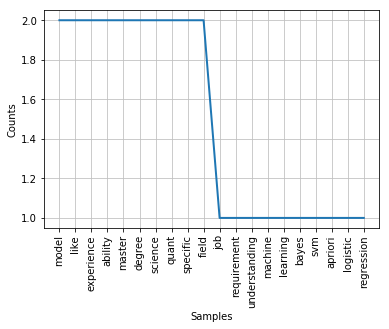

In [53]:
import matplotlib.pyplot as plt

fdist.plot(20, cumulative=False)

 # 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Tfidf vectorizer needs a string per document, so convert it.
lemmatized_str_per_doc = []
for l in lemmatized:
    lemmatized_str_per_doc.append(' '.join(l))
    
tfidf = TfidfVectorizer(max_features=20)
feature_matrix = tfidf.fit_transform(lemmatized_str_per_doc)

feature_names = tfidf.get_feature_names()
df = pd.DataFrame(data=feature_matrix.toarray(), columns=feature_names)
df.head()

,ability,analysis,analytics,business,data,experience,learning,machine,model,new,opportunity,product,science,scientist,skill,solution,statistical,team,work,year
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,0.519169,0.000000,0.000000,0.000000,0.164715,0.343731,0.219589,0.233182,0.481620,0.000000,0.0,0.000000,0.404119,0.000000,0.215143,0.0,0.000000,0.000000,0.202561,0.000000
2,0.124021,0.100981,0.000000,0.100981,0.314782,0.410560,0.314738,0.334221,0.115051,0.250186,0.0,0.231986,0.193075,0.112903,0.205577,0.0,0.000000,0.464061,0.193554,0.105183
3,0.000000,0.000000,0.208257,0.508704,0.396438,0.000000,0.176170,0.187076,0.386391,0.000000,0.0,0.000000,0.162107,0.379174,0.345206,0.0,0.190096,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


## Stretch Goals

 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.